In [107]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [108]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 108MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 91.0MB/s]


In [109]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [110]:
def parse_data_from_input(filename):

  with open(filename) as file:

    csv_reader = csv.reader(file, delimiter=',')

    row_count = sum(1 for i in csv_reader) - 1
    file.seek(0)
    next(csv_reader, None)

    images = np.empty(shape = (row_count, 28, 28), dtype = float)
    labels = np.empty(shape = row_count, dtype = int)

    for i, row in enumerate(csv_reader):
        labels[i] = row[0]
        images[i] = np.array(row[1:], dtype = float).reshape(28,28)


    return images, labels

In [111]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: int64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: int64


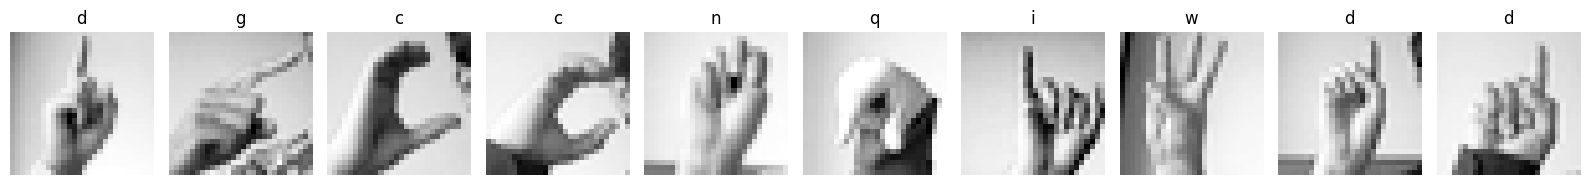

In [112]:
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

In [113]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  training_images = np.expand_dims(training_images, axis = -1)
  validation_images = np.expand_dims(validation_images, axis = -1)

  train_datagen = ImageDataGenerator(rescale = 1/255,
                                     rotation_range=20,
                                     zoom_range=0.3)

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)


  validation_datagen = ImageDataGenerator(rescale = 1/255)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [115]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

In [116]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') >= 0.95:
      print(f"\nReached 95% validation accuracy at epoch {epoch+1}, stopping training.")
      self.model.stop_training = True

In [117]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(26, activation = 'softmax')
  ])

  model.compile(optimizer = 'Adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [118]:
stop_training_callback = CustomCallback()
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks = [stop_training_callback])

Epoch 1/15
858/858 [==============================] - 18s 20ms/step - loss: 1.6681 - accuracy: 0.4742 - val_loss: 0.6582 - val_accuracy: 0.7832
Epoch 2/15
858/858 [==============================] - 14s 17ms/step - loss: 0.7002 - accuracy: 0.7648 - val_loss: 0.3354 - val_accuracy: 0.9069
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.4472 - accuracy: 0.8459 - val_loss: 0.2501 - val_accuracy: 0.9190
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 0.3539 - accuracy: 0.8799 - val_loss: 0.2123 - val_accuracy: 0.9289
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.2679 - accuracy: 0.9087 - val_loss: 0.2265 - val_accuracy: 0.9294
Epoch 6/15
858/858 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9210
Reached 95% validation accuracy at epoch 6, stopping training.
858/858 [==============================] - 13s 15ms/step - loss: 0.2295 - accuracy: 0.9210 - val_loss: 0.1739 - val_accur

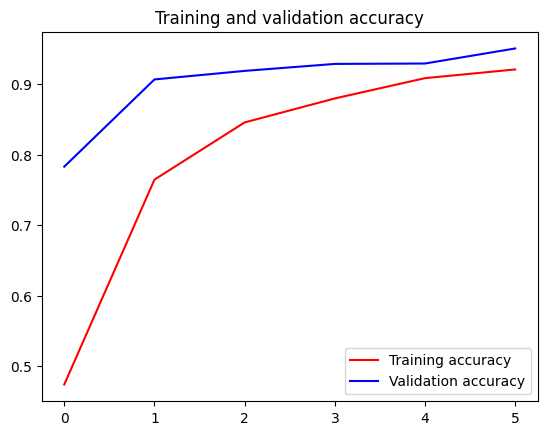

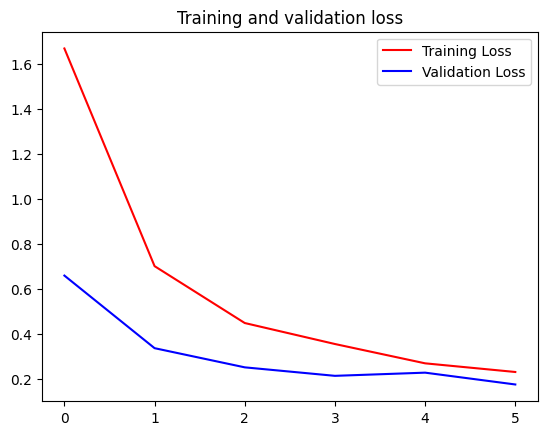

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()